# Решающее дерево

Отметим, что решающее дерево состоит из вершин, в которых записывает некоторое условие, а в листах дерева - прогноз. Условия во внутренних вершинах выбираются простыми. Наиболее частый вариант - проверка лежит ли значение некоторого признака $x^j$ левее порога $t$:

$[x^j \leq t]$

Легко заметить, что такое условие зависит только от одного признака. Прогноз в листе является вещественным числом, если решается задача регрессии. Если же решается задача классификации, то в качестве прогноза выступает или класс или распределение вероятностей классов.

Запишем некоторую функцию ошибки следующим образом: есть набор данных $X_m$, есть номер рассматриваемого признака $j$ и есть порог $t$.

$L(X_m, j, t) \rightarrow \underset{j,t}{min}$

Осуществим перебор всех возможных признаков $j$ и порогов $t$ для этих признаков. Каждый раз исходное множество будет разбиваться на два подмножества:

$X_l = \{x \in X_m | [ x^j \leq t ] \}$ и $X_к = \{x \in X_m | [ x^j > t ] \}$

Такую процедуру можно продолжить для каждого получившегося множества (рекурсивно вызывать функцию деления для получающихся подмножеств).

Необходимо отметить, что если вершина была объявлена листом, необходимо сделать прогноз для этого листа. Для задачи регрессии берется среднее значение по этой выборке,
для задачи классификации возвращается тот класс, которые наиболее популярен в выборке. Можно указывать вероятность классов в листе.

Для каждого разбиения необходимо расчитывать функцию потерь:

$L(X_m, j, t) = \frac{|X_l|}{|X_m|}H(X_l) + \frac{|X_r|}{|X_m|}H(X_r)$,

где $H(X)=\sum\limits_{k=1}^{K} p_k(1 - p_k)$ - критерий информативности Джинни.

$p_k$ - доля объектов класса $k$ в выборке X:

$p_k=\frac{1}{|X|}\sum\limits_{i \in X}{[y_i = k]}$

В задаче работаем только с числовыми данными и строим дерево классификации.

Данные сгенерированы случайным образом.

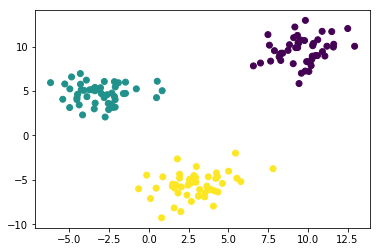

In [2]:
from sklearn.datasets import make_blobs, make_moons
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
%matplotlib inline

# x, y = make_moons(n_samples=100, noise=0.1)
x, y = make_blobs(n_samples=150, n_features=2, cluster_std=1.4)
plt.scatter(x[:,0], x[:,1], c = y)


## Задание 1

Напишите функцию, которая получает на вход матрицу данных ($x$) и целевые переменные ($y$), на выходе функция возвращает номер признака ($i$), порог разбиения($t$), значение в листовой вершине слева ($y_l$) и значение в листовой вершине справа ($y_r$).
Постарайтесь учесть, что пороги разбиения должны лежать строго по середине между ближайшими обектами.

Необходимо учесть:

1. Разбиений не требуется, если в получившемся множестве находятся объекты одного класса.
2. Количество различных классов объектов в целевой переменной может быть больше двух.


In [3]:
def createSortedTuple(numberArray):
    tuples = [ n for n in enumerate(numberArray) ]
    tuples.sort(key=lambda v: v[1])
    return tuples

uniqueCategories = list(set(y))
createEmptyCategoriesCountDict = lambda: dict((value, 0) for (key, value) in enumerate(uniqueCategories))

def findCategoryDiffsByFeatureAndEdge(sortedTuples, categories, edge):
    left = createEmptyCategoriesCountDict()
    right = createEmptyCategoriesCountDict()

    for (i, value) in sortedTuples:
        category = categories[i]
        if (value < edge): 
            left[category] = left[category] + 1
        else: 
            right[category] = right[category] + 1
    
    return left, right

def findCategoryDispersion(left, right, category):
    anotherCategories = set(left)
    anotherCategories.remove(category)
    anotherCategories = list(anotherCategories)

    anotherLeftSum = 0
    anotherRightSum = 0
    for anotherCategory in anotherCategories:
        anotherLeftSum = anotherLeftSum + left[anotherCategory]
        anotherRightSum = anotherRightSum + right[anotherCategory]
    
    leftDispersion = anotherLeftSum + right[category]
    rightDispersion = anotherRightSum + left[category]
    
    return min(leftDispersion, rightDispersion)

def findMinimalEdgeBySortedTuples(sortedTuples, categories):
    uniqueCategories = list(set(y))
    valuesCount = len(categories)
    categoriesDiffs = []
    
    minimalCategoriesDispersionTuples = dict((value, (-1, valuesCount)) for (key, value) in enumerate(uniqueCategories))

    for i in range(len(sortedTuples) - 1):
        first = sortedTuples[i][1]
        second = sortedTuples[i + 1][1]
        edge = (second + first) / 2;

        left, right = findCategoryDiffsByFeatureAndEdge(sortedTuples, categories, edge)
        
        for category in uniqueCategories:
            dispersion = findCategoryDispersion(left, right, category)
            
#             if (category == 1):
#                 print(edge, left, right, dispersion, category)

            if (dispersion < minimalCategoriesDispersionTuples[category][1]):
                minimalCategoriesDispersionTuples[category] = (i, dispersion)
        
    minimalCategoryDispersion = {
        'category': uniqueCategories[0],
        'index': -1,
        'dispersion': valuesCount
    }
    
#     print(minimalCategoriesDispersionTuples)
    for category in uniqueCategories:
        categoryDispersionTuple = minimalCategoriesDispersionTuples[category]
        if (categoryDispersionTuple[1] < minimalCategoryDispersion['dispersion']):
            minimalCategoryDispersion = {
                'category': category,
                'index': categoryDispersionTuple[0],
                'dispersion': categoryDispersionTuple[1]
            }
            
    edgeIndex = minimalCategoryDispersion['index'];
    dispersion = minimalCategoryDispersion['dispersion'];
    category = minimalCategoryDispersion['category'];
    
    leftPoint = sortedTuples[edgeIndex]
    rightPoint = sortedTuples[edgeIndex + 1]
    
    edge = (leftPoint[1] + rightPoint[1]) / 2;
    
    return dispersion, leftPoint[1], rightPoint[1], edge

def findEdge(values, categories):
    minimalCategoryDispersion = {
        'destination': None,
        'leftPointValue': None,
        'rightPointValue': None,
        'edge': None,
        'dispersion': len(values)
    }
    
    for destination in range(len(values[0])):
        sortedTuples = createSortedTuple(values[:, destination])
        dispersion, leftPointValue, rightPointValue, edge = findMinimalEdgeBySortedTuples(sortedTuples, categories)
        
        if(dispersion < minimalCategoryDispersion['dispersion']):
            minimalCategoryDispersion = {
                'destination': destination,
                'leftPointValue': leftPointValue,
                'rightPointValue': rightPointValue,
                'edge': edge,
                'dispersion': dispersion
            }
    
    return minimalCategoryDispersion
    
findEdge(x, y)

{'destination': 1,
 'leftPointValue': -1.9882073805248193,
 'rightPointValue': 2.0792042690291166,
 'edge': 0.04549844425214866,
 'dispersion': 0}

После первого разбиения мы считаем, что в листе дерева будет находиться класс объектов, которых больше всего в этом множестве. Реализуйте классификатор дерева решений в виде функции, которая получает на вход признаки объекта - $x$, на выходе метка класса - $y_{pred}$. Величину порога деления возьмите с точностью до 5 знака после запятой.

Визуализируйте получившиеся результаты классификатора на плоскости. Для этого воспользуйтесь кодом ниже, чтобы построить поверхность. $t$ - порог разбиения $i$ - номер признака.

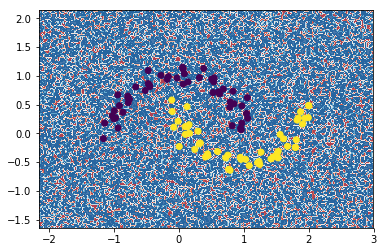

In [19]:
def tree_clf(x):
    y_pred = list()  
    for it in x.transpose():
        # Алгоритм классификации
        y_pred.append(np.round(np.random.random())) # Пока дерево классифицирует случайный класс.
    return np.array(y_pred)


h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree_clf(np.stack((xx0.ravel(),xx1.ravel())))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)


Проведите процесс разбиение в получившихся листах дерева до глубины 2. Перепишите функцию классификатора. Визуализируйте результаты классификации.

## Задание №2. Кросс-проверка и  подбор параметров для дерева решений

В задании воспользуемся готовой функцией для построения дерева решений DecisionTreeClassifier. Использовать будем данные с платформы kaggle, где проводится классификация пациентов на здоровых ('Normal') и с заболеванием ('Abnormal'). Подробности о признаках тут: https://www.kaggle.com/uciml/biomechanical-features-of-orthopedic-patients/home
Необходимо построить кросс-проверку (cross_val_score в sklearn.cross_validation ) алгоритма "Дерево решений" на 5 подвыборках, причем дерево должно не ограничиваться по глубине (max_depth), в листовой вершине дерева должен быть хотя бы один объект (min_samples_leaf), минимальное количество объектов должно быть не менее 2 для разбиения (min_samples_split) и random_state=42.
Оцените результаты получившиеся на валидационной выборке с использованием F1-меры, точности и полноты (в параметре scoring к методу cross_val_score необходимо использовать 'f1_weighted', 'precision_weighted', 'recall_weighted'). 

Точность и полнота позволяют провести оценку классификации.
Точность (Precision) - это отношение количества правильно классифицированных объектов класса к количеству объектов, которые классифицированы как данный класс.
Полнота (Recall) - это отношение количества правильно классифицированных объектов класса к количеству объектов данного класса в тестовой выборке.
Введем следующие понятия:

$TP$  — истино-положительное решение;
$TN$ — истино-отрицательное решение;
$FP$ — ложно-положительное решение;
$FN$ — ложно-отрицательное решение.

Тогда 

$Precision = \frac{TP}{TP+FP}$, 

$Recall = \frac{TP}{TP+TN}$.

Точность и полнота изменяются в интервале [0, 1]. Чем выше точность и полнота, тем лучше классификатор. Однако, по двум метрикам очень сложно чудить о качестве классификации, поэтому используют F1-меру:

$F1 = \frac{2 \times Precision \times Recall}{Precision + Recall}$

В нашем задании будем использовать взвешенную сумму F1-меры, точности и полноты для каждого класса.

In [172]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics.classification import f1_score, precision_score, recall_score

In [173]:
df = pd.read_csv('column_2C_weka.csv')
df.columns

Index(['pelvic_incidence', 'pelvic_tilt numeric', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'class'],
      dtype='object')

Следует отметить, что по одной метрике не очень удобно проводить оценку. В этой связи, лучшим вариантом кросс-проверки будет использование функции cross_validate из sklearn.model_selection. В нее можно передать несколько метрик и оценивать каждый шаг кросс проверки по нескольким метрикам, причем для тренировочного (return_train_score=True) и валидационного набора данных.
Оцените результаты на тренировочном и тестовом наборе. Объясните получившиеся результаты.


In [115]:
from sklearn.model_selection import cross_validate

Подбор параметров для модели можно проводить с помощью GridSearchCV из sklearn.model_selection. Возьмите параметр максимальной глубины дерева от 1 до 20. Относительно этого параметра вычислите средевзвешенную F1-меру для 5 разбиений. Постройте график зависимости F1-меры от максимальной глубины дерева. Получить результаты построения можно методом cv_results_.

Проведите оценку результатов. Почему на тестовой выборке F1-мера не увеличивается. 

In [ ]:
from sklearn.model_selection import GridSearchCV

То же самое проведите для параметра min_samples_split от 2 до 20.

Проведите оценку результатов. 

То же самое проведите для параметра min_samples_leaf от 1 до 10.

Проведите оценку результатов. 